## Variant effect prediction: Three models for classifying pathogenic mutations in human genes

To run this demo tutorial, please make sure that you've downloaded the GitHub repo <> and that you've changed the 'main_path' variable below to point to where your installation lives on your local system. If you are not using Google Colab to run, please also set the 'using_google_colab' variable to False.

In [1]:
# Change this to whatever your directory you're working from is - this should be
# the head level with Code and Data directories.
main_path = '/content/drive/MyDrive/DeepLearning_Summer2022/Final_Project/'

# Input the uniprot ID that you would like to make predictions for here.
# For this demonstration, I will use the KCNQ1 gene 
# (https://www.uniprot.org/uniprotkb/P51787/entry)
uniprot_id = 'P51787'

# Set to False if you're running locally
using_google_colab = True

# Set to False if you're running a non-KCNQ1 protein and you haven't downloaded
# the gnomAD table for the protein of interest
run_gnomad = True

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import keras
import numpy as np
from keras import models
from keras import layers
from keras.layers import GRU, LSTM
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
import copy
import random as python_random
import tensorflow as tf
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint
from google.colab import files
import sklearn.preprocessing
import scipy
import seaborn as sns

import sys
import importlib

# set seeds
np.random.seed(768)
python_random.seed(869)
tf.random.set_seed(1234)

if using_google_colab:
  from google.colab import drive
  drive.mount('/content/drive')

sys.path.append(main_path+"Code")

# This is our library with our class definitions
import vep
importlib.reload(vep)

Mounted at /content/drive


<module 'vep' from '/content/drive/MyDrive/DeepLearning_Summer2022/Final_Project/Code/vep.py'>

## Model 1 - predicting pathogenicity based just on the original ("wildtype") and the mutant amino acids

In [3]:
# Instantiate a Protein class for our protein (specified by Uniprot ID) of 
# interest
uniprot1 = vep.Protein(uniprot_id)

In [4]:
# Load a Model1 instance and read in our trained Keras model
m1 = vep.Model1()
m1.load_nn_model_from_weights(main_path+'Code/Trained_Model_Weights/Model1')

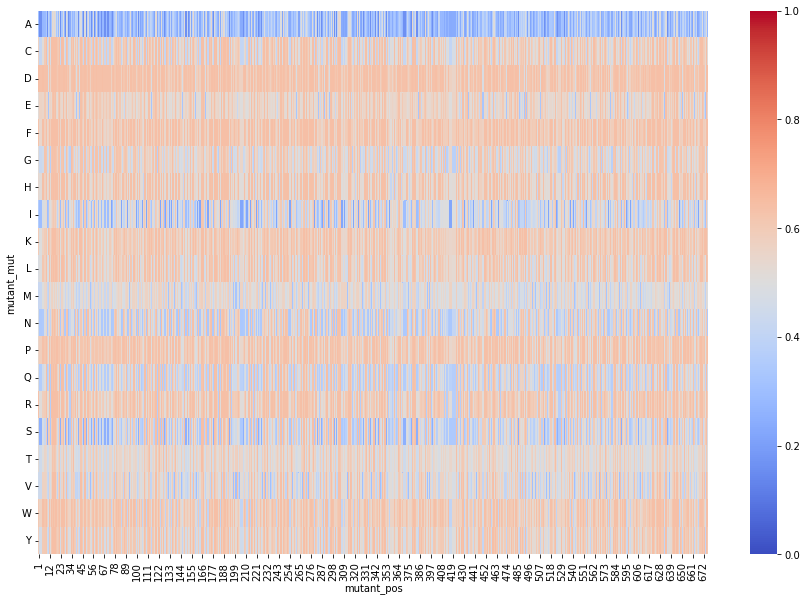

In [5]:
# Generate and plot a heat map for all possible single-site substitutions
uniprot1.test_all_single_aa_subs(m1)
uniprot1.plot_heatmap_pathogenicity()

In [6]:
# Display our final predictions
uniprot1.predictions

,uniprot,mutant_wt,mutant_mut,mutant_pos,Sequence,Length,pred_pathogenic
0,P51787,M,A,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.324157
1,P51787,M,C,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.568725
2,P51787,M,D,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.640716
3,P51787,M,E,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.521455
4,P51787,M,F,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.626046
...,...,...,...,...,...,...,...
13515,P51787,S,S,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.476831
13516,P51787,S,T,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.506383
13517,P51787,S,V,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.569596
13518,P51787,S,W,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.637805


## Model 2

In [7]:
# Load in a Model2 instance - reminder, this uses amino acid properties in a 
# bi-directional GRU model
m2 = vep.Model2(main_path+'Data/precursor_files/amino_acid_properties.csv')
m2.load_nn_model_from_weights(main_path+'Code/Trained_Model_Weights/Model2_clustered')

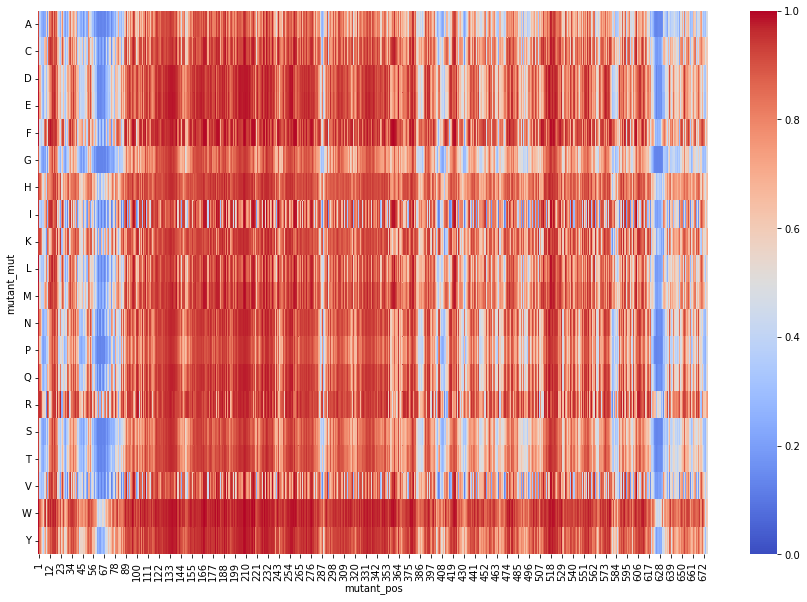

In [8]:
uniprot2 = vep.Protein(uniprot_id)
uniprot2.test_all_single_aa_subs(m2)
uniprot2.plot_heatmap_pathogenicity()

In [9]:
uniprot2.predictions

,uniprot,mutant_wt,mutant_mut,mutant_pos,Sequence,Length,pred_pathogenic
0,P51787,M,A,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.922557
1,P51787,M,C,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.943632
2,P51787,M,D,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.982255
3,P51787,M,E,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.988003
4,P51787,M,F,1,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.987160
...,...,...,...,...,...,...,...
13515,P51787,S,S,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.521694
13516,P51787,S,T,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.505762
13517,P51787,S,V,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.477422
13518,P51787,S,W,676,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...,676,0.593022


## Model 3

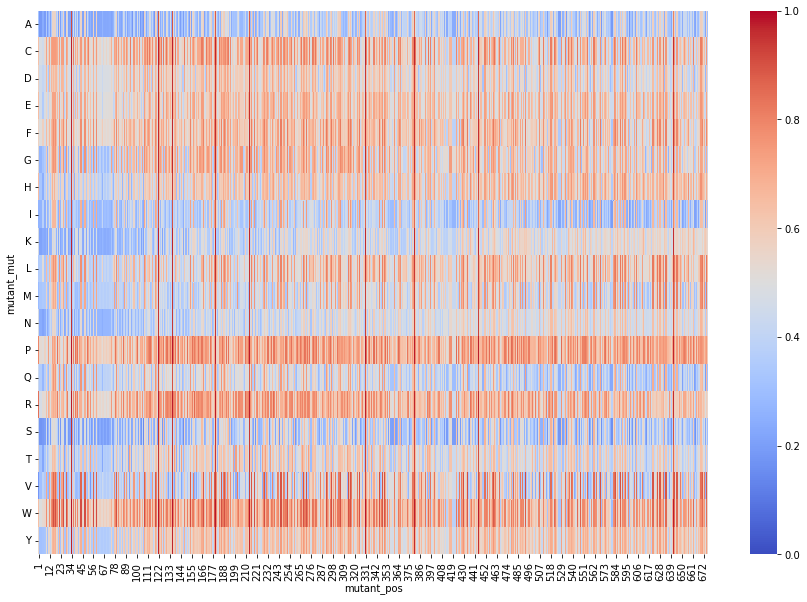

In [10]:
# Load in a Model3 instance (using protein encodings from Alley et al 2019) -
# note that you will need to give the path to the pickled dictionary of 
# encodings as an argument to Model3()
prot_enc_file = main_path+'Data/protein_full_length_encodings.pickle'
m3 = vep.Model3(prot_enc_file)
m3.load_nn_model_from_weights(main_path+'Code/Trained_Model_Weights/Model3_random')

# Load in our Protein instance, generate predictions, and plot heatmap
uniprot3 = vep.Protein(uniprot_id)
uniprot3.test_all_single_aa_subs(m3)
uniprot3.plot_heatmap_pathogenicity()

[[1.         0.29971272]
 [0.29971272 1.        ]]
62.41% of predictions agree on classification between Model 2 and 3


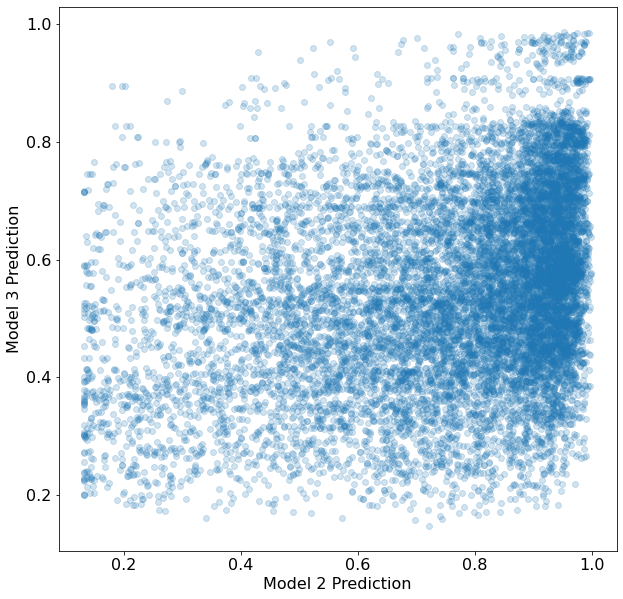

In [11]:
# Compare Model 2 (with clustered split) and Model 3 (with random split)
# predictions
pred_2 = uniprot2.predictions
pred_3 = uniprot3.predictions
preds = pred_2.merge(pred_3,on=['mutant_mut','mutant_pos','mutant_wt'],suffixes=['_model2','_model3'])

# Plot the scatter between the two
plt.figure(figsize=(10,10))
plt.plot(preds['pred_pathogenic_model2'],preds['pred_pathogenic_model3'],'o',alpha=0.2)
plt.xlabel('Model 2 Prediction',fontsize=16)
plt.ylabel('Model 3 Prediction',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Get the Pearson correlation coefficient
print(np.corrcoef(preds['pred_pathogenic_model2'],preds['pred_pathogenic_model3']))

# Find out how many of the predictions agree with each other
N = len(preds)
N_disagree = len(preds.query('((pred_pathogenic_model2 >= 0.5) and (pred_pathogenic_model3 < 0.5)) or ((pred_pathogenic_model2 < 0.5) and (pred_pathogenic_model3 >= 0.5))'))

print('{:.2f}% of predictions agree on classification between Model 2 and 3'.format((1-(N_disagree/N))*100))

## Compare to gnomAD allele frequencies
Note that you will need to download the allele frequencies from gnomAD for any protein beyond KCNQ1 that you would like to run.

In [12]:
# Read in our downloaded list of allele frequencies (along with other info)
kncq1_gnomad_file = main_path + 'Data/precursor_files/gnomAD_KCNQ1_allele_frequencies_7-29-22.csv'
df_kcnq1 = pd.read_csv(kncq1_gnomad_file)[['HGVS Consequence','Allele Frequency']]

# Need to format our missense mutations so that they match our predictions df
d_aa_codes = {'Ser':'S','Thr':'T','Asn':'N','Gln':'Q',
              'Cys':'C','Gly':'G','Pro':'P','Asp':'D',
              'Glu':'E','Arg':'R','Lys':'K','His':'H',
              'Ala':'A','Val':'V','Ile':'I','Leu':'L',
              'Met':'M','Phe':'F','Tyr':'Y','Trp':'W'}

# Format our gnomAD set to match column names for our predictions
df_kcnq1['mutant_mut'] = [d_aa_codes[x[-3:]] for x in df_kcnq1['HGVS Consequence']]
df_kcnq1['mutant_pos'] = [int(x[5:-3]) for x in df_kcnq1['HGVS Consequence']]
df_kcnq1['mutant_wt'] = [d_aa_codes[x[2:5]] for x in df_kcnq1['HGVS Consequence']]

df_kcnq1.head()

,HGVS Consequence,Allele Frequency,mutant_mut,mutant_pos,mutant_wt
0,p.Pro7Ser,0.000188,S,7,P
1,p.Pro21Ser,0.000054,S,21,P
2,p.Gly22Arg,0.000038,R,22,G
3,p.Ala46Thr,0.000060,T,46,A
4,p.Ala46Glu,0.000076,E,46,A


Total number of KCNQ1 ClinVar missense annotations: 615
Total number of KCNQ1 ClinVar pathogenic variants: 149
Total number of KCNQ1 ClinVar uncertain variants: 457
Total number of KCNQ1 ClinVar benign variants: 10
Total number of KCNQ1 gnomAD alle frequencies: 321
Total number of KCNQ1 ClinVar missense mutations with known allele frequences: 72
Total number of KCNQ1 pathogenic mutations with known allele frequencies: 5
Total number of KCNQ1 uncertain mutations with known allele frequencies: 60
Total number of KCNQ1 benign mutations with known allele frequencies: 7


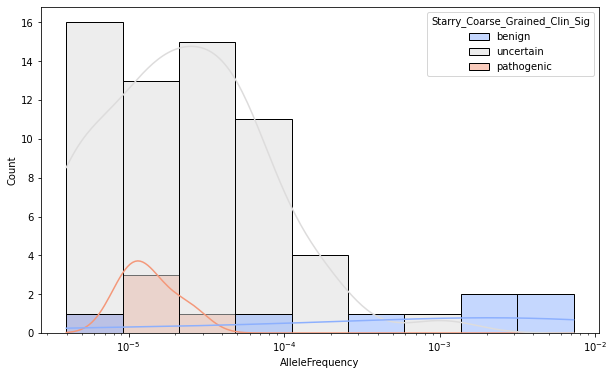

In [13]:
# First, let's compare our ClinVar annotations to the gnomAD data

# Download our ClinVar original data, and restrict just to entries for KCNQ1
df_clinvar = pd.read_csv(main_path+'Data/precursor_files/EVE_ClinVar_cleaned_annotated_GRCh38.csv')
df_clinvar = df_clinvar.query('GeneSymbol == "KCNQ1"')[['GeneSymbol','mutant','Starry_Coarse_Grained_Clin_Sig']]

# Format this data frame to make our missense calling values consistent between 
# data sources
df_clinvar['mutant_mut'] = [x[-1] for x in df_clinvar['mutant']]
df_clinvar['mutant_pos'] = [int(x[1:-1]) for x in df_clinvar['mutant']]
df_clinvar['mutant_wt'] = [x[0] for x in df_clinvar['mutant']]

# For our ClinVar annotated variants, get the allele frequency if available by 
# merging dataframes
x = df_clinvar.merge(df_kcnq1,on=['mutant_wt','mutant_pos','mutant_mut'],how='left')
x = x.rename(columns={'Allele Frequency':'AlleleFrequency'})

# Get statistics for how many variants are overlapping between ClinVar and 
# gnomAD
print('Total number of KCNQ1 ClinVar missense annotations: {}'.format(len(df_clinvar)))
print('Total number of KCNQ1 ClinVar pathogenic variants: {}'.format(len(x.query('Starry_Coarse_Grained_Clin_Sig == "pathogenic"'))))
print('Total number of KCNQ1 ClinVar uncertain variants: {}'.format(len(x.query('Starry_Coarse_Grained_Clin_Sig == "uncertain"'))))
print('Total number of KCNQ1 ClinVar benign variants: {}'.format(len(x.query('Starry_Coarse_Grained_Clin_Sig == "benign"'))))
print('Total number of KCNQ1 gnomAD alle frequencies: {}'.format(len(df_kcnq1)))
print('Total number of KCNQ1 ClinVar missense mutations with known allele frequences: {}'.format(len(x.dropna())))
print('Total number of KCNQ1 pathogenic mutations with known allele frequencies: {}'.format(len(x.query('Starry_Coarse_Grained_Clin_Sig == "pathogenic" and AlleleFrequency > 0'))))
print('Total number of KCNQ1 uncertain mutations with known allele frequencies: {}'.format(len(x.query('Starry_Coarse_Grained_Clin_Sig == "uncertain" and AlleleFrequency > 0'))))
print('Total number of KCNQ1 benign mutations with known allele frequencies: {}'.format(len(x.query('Starry_Coarse_Grained_Clin_Sig == "benign" and AlleleFrequency > 0'))))

# Plot our distributions of allele frequencies (where available) for ClinVar 
# coarse-grained definitions of benign, uncertain, and pathogenic
plt.figure(figsize=(10,6))
ax = sns.histplot(data = x, x = "AlleleFrequency", kde = True, 
             hue = "Starry_Coarse_Grained_Clin_Sig",log_scale=True,
             common_bins=True,stat='count',palette='coolwarm',
             hue_order=['benign','uncertain','pathogenic'])

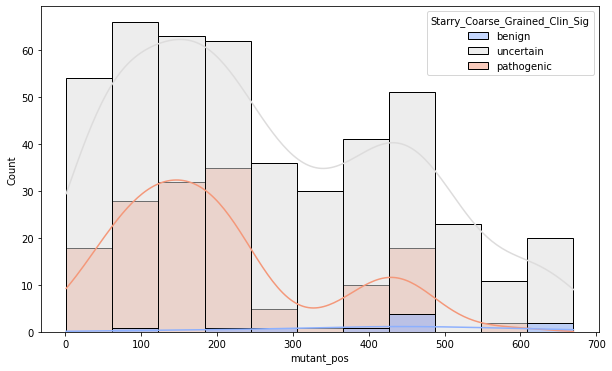

In [14]:
# Plot our distributions of where in the KCNQ1 protein sequnce ClinVar variants 
# are found, separating by coarse-grained definitions of benign, uncertain, 
# and pathogenic. The goal is to get an understanding of the bias our trained
# models might have in predicting variants.
plt.figure(figsize=(10,6))
ax = sns.histplot(data = x, x = "mutant_pos", kde = True, 
             hue = "Starry_Coarse_Grained_Clin_Sig",
             common_bins=True,stat='count',palette='coolwarm',
             hue_order=['benign','uncertain','pathogenic'])

[[ 1.         -0.00130146]
 [-0.00130146  1.        ]]
[[ 1.         -0.07983493]
 [-0.07983493  1.        ]]
[[ 1.         -0.00943307]
 [-0.00943307  1.        ]]


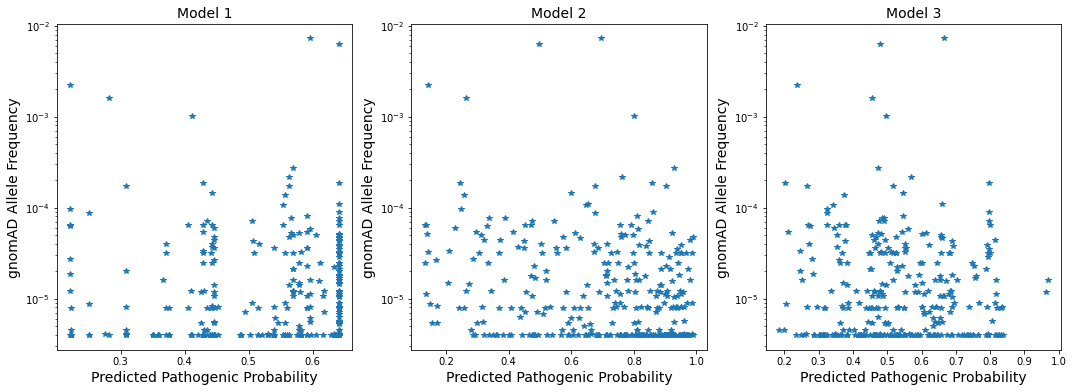

In [15]:
# If we want to compare our model predictions to KCNQ1 allele frequencies (e.g.
# if our variable run_gnomad = True as set in the top cell), plot the scatter 
# for all models

if run_gnomad:
  
  # Plot model 1 predicted pathogenicity vs allele frequency
  plt.figure(figsize=(18,6))
  ax1 = plt.subplot(1,3,1)
  df_m1 = df_kcnq1.merge(uniprot1.predictions,on=['mutant_mut','mutant_pos','mutant_wt'])
  print(np.corrcoef(df_m1['pred_pathogenic'],df_m1['Allele Frequency']))
  ax1.semilogy(df_m1['pred_pathogenic'],df_m1['Allele Frequency'],'*')
  ax1.set_xlabel('Predicted Pathogenic Probability',fontsize=14)
  ax1.set_ylabel('gnomAD Allele Frequency',fontsize=14)
  ax1.set_title('Model 1',fontsize=14)

  # Plot predictions versus allele frequency for Model 2
  df_m2 = df_kcnq1.merge(uniprot2.predictions,on=['mutant_mut','mutant_pos','mutant_wt'])
  print(np.corrcoef(df_m2['pred_pathogenic'],df_m2['Allele Frequency']))
  ax2 = plt.subplot(1,3,2)
  ax2.semilogy(df_m2['pred_pathogenic'],df_m2['Allele Frequency'],'*')
  ax2.set_xlabel('Predicted Pathogenic Probability',fontsize=14)
  ax2.set_ylabel('gnomAD Allele Frequency',fontsize=14)
  ax2.set_title('Model 2',fontsize=14)

  # Plot predictions versus allele frequency for Model 3
  df_m3 = df_kcnq1.merge(uniprot3.predictions,on=['mutant_mut','mutant_pos','mutant_wt'])
  print(np.corrcoef(df_m3['pred_pathogenic'],df_m3['Allele Frequency']))
  ax3 = plt.subplot(1,3,3)
  ax3.semilogy(df_m3['pred_pathogenic'],df_m3['Allele Frequency'],'*')
  ax3.set_xlabel('Predicted Pathogenic Probability',fontsize=14)
  ax3.set_ylabel('gnomAD Allele Frequency',fontsize=14)
  ax3.set_title('Model 3',fontsize=14)